# Naive "all irrelevant" Baseline Classifier

**Baseline Classifier, which predicts every datapoint as negative, to compare against more sophisticated classifiers due to class imbalance**
**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch.nn as nn

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold,
    plot_skorch_history
)

from sklearn.dummy import DummyClassifier
from joblib import dump
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

Naive Baseline


Final Threshold: 0.50 (fixed, Dummy has no tunable threshold)
F2-score with default threshold (0.5): 0.000

Test Set Performance:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       146
           1       0.00      0.00      0.00        54

    accuracy                           0.73       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.53      0.73      0.62       200

Additional Metrics:
Accuracy   0.730
F2-score   0.000
AUC-ROC    0.500
AUC-PR     0.270



c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


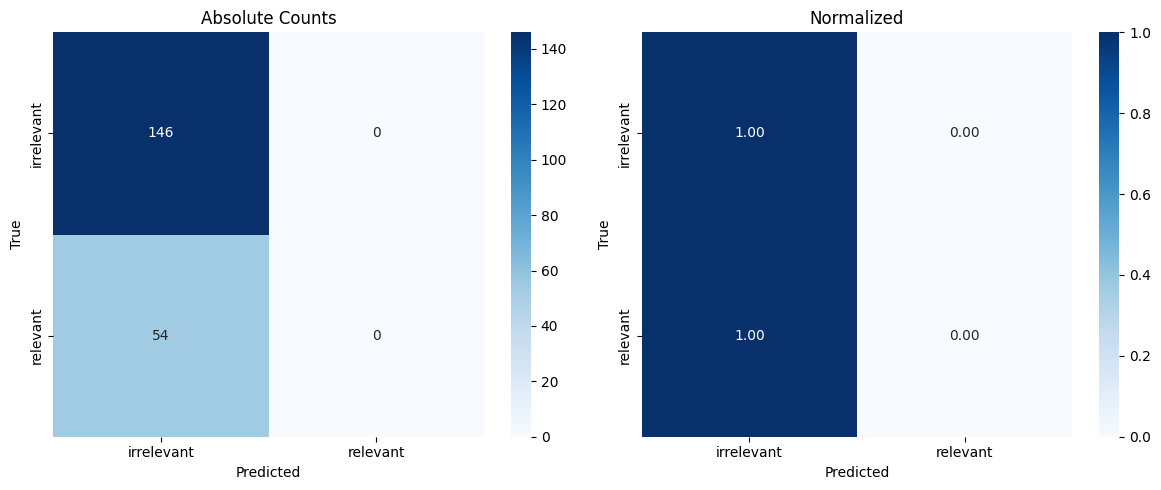

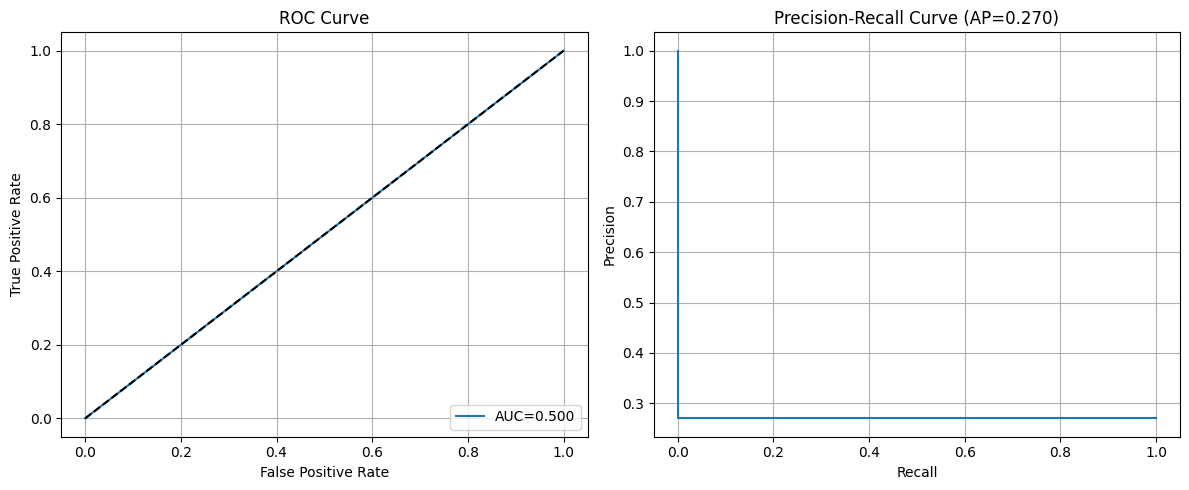


Model saved as model_baseline_always_negative.joblib


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3

In [3]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

model_name = "baseline_always_negative"

# Pipeline (same structure as other models, just replacing clf)
pipeline_dummy = Pipeline([
    ("clf", DummyClassifier(strategy="most_frequent"))
])

# Fit on training data
pipeline_dummy.fit(X_dev, y_dev)

# Predictions on test set
y_test_pred = pipeline_dummy.predict(X_test)
y_test_proba = pipeline_dummy.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: 0.50 (fixed, Dummy has no tunable threshold)")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and PR curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# "CV performance" for Dummy (no HPO, just reuse training data)
cv_pred_dummy = pipeline_dummy.predict(X_dev)
cv_proba_dummy = pipeline_dummy.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Structured results summary (same format as EuroBERT etc.)
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'basic',
    'optimization_method': 'None (Dummy Baseline)',
    'cv_results': {
        'cv_performance_metrics': cv_metrics
    },
    'test_results': {
        'threshold_used': 0.5, 
        'test_performance_metrics': test_metrics,
        'formatted_report': test_report_str
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the model (consistent with other pipelines)
dump({
    'model': pipeline_dummy,
    'results_summary': results_summary
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")
